In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models
import random
import numpy as np


In [2]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
TRAIN_DIR = '../input/seg_train/'
TEST_DIR = '../input/seg_test/'

batch_size = 32

model_name = "ResNet101"

In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

In [5]:
# Data Loader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size, num_workers=2)


In [6]:
# ResNet-18モデルの定義
class CustomResNet101(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet101, self).__init__()
        self.resnet = models.resnet101(weights="IMAGENET1K_V1")  # 事前学習済みのResNet-18モデルをロード
        # 最終の全結合層を入れ替えて、出力クラスの数に合わせる
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [7]:
# 2. モデルの構築
model = CustomResNet101(num_classes=6).to(device)


In [8]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [9]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [10]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.6407322347096113, Val Loss: 0.4600984997789752, Train Acc: 0.7645004987886561, Val Acc: 0.8346666666666667


Epoch 2/50, Train Loss: 0.44437496168496404, Val Loss: 0.41168590208039957, Train Acc: 0.841100185264358, Val Acc: 0.848


Epoch 3/50, Train Loss: 0.3788200980860349, Val Loss: 0.3247722333614179, Train Acc: 0.8650420407581587, Val Acc: 0.8916666666666667


Epoch 4/50, Train Loss: 0.34706171619021187, Val Loss: 0.32891014230219606, Train Acc: 0.8782243123842097, Val Acc: 0.883


Epoch 5/50, Train Loss: 0.3363235770941597, Val Loss: 0.317843425711815, Train Acc: 0.8836397320792362, Val Acc: 0.8903333333333333


Epoch 6/50, Train Loss: 0.31078918152339924, Val Loss: 0.31397062655478875, Train Acc: 0.8904090066980191, Val Acc: 0.893


Epoch 7/50, Train Loss: 0.2883351108305939, Val Loss: 0.3029421756992691, Train Acc: 0.8942568049023799, Val Acc: 0.8963333333333333


Epoch 8/50, Train Loss: 0.2812027241099099, Val Loss: 0.3152824345421284, Train Acc: 0.8989596693743765, Val Acc: 0.894


Epoch 9/50, Train Loss: 0.2698553644256777, Val Loss: 0.343027078566399, Train Acc: 0.8996009690751033, Val Acc: 0.8853333333333333


Epoch 10/50, Train Loss: 0.2612071217518283, Val Loss: 0.3156449030292161, Train Acc: 0.9052301553370387, Val Acc: 0.888


Epoch 11/50, Train Loss: 0.24384275532952726, Val Loss: 0.3024987018211408, Train Acc: 0.9093629756306114, Val Acc: 0.8943333333333333


Epoch 12/50, Train Loss: 0.23970877841863458, Val Loss: 0.3604608816391927, Train Acc: 0.9131395183126693, Val Acc: 0.886


Epoch 13/50, Train Loss: 0.23101658378323736, Val Loss: 0.2931341312607711, Train Acc: 0.9162747612940003, Val Acc: 0.901


Epoch 14/50, Train Loss: 0.23137053338700234, Val Loss: 0.3333071280776107, Train Acc: 0.9171298275616361, Val Acc: 0.891


Epoch 15/50, Train Loss: 0.2136378403599948, Val Loss: 0.3201702231091715, Train Acc: 0.923614080091207, Val Acc: 0.894


Epoch 16/50, Train Loss: 0.21139991064832364, Val Loss: 0.2940718084276515, Train Acc: 0.9211201368106028, Val Acc: 0.9033333333333333


Epoch 17/50, Train Loss: 0.2009079638894086, Val Loss: 0.3004028684870796, Train Acc: 0.9244691463588428, Val Acc: 0.8976666666666666


Epoch 18/50, Train Loss: 0.19627962080276992, Val Loss: 0.295026346519738, Train Acc: 0.9298133105315662, Val Acc: 0.9


Epoch 19/50, Train Loss: 0.1898356089496041, Val Loss: 0.31756911548863886, Train Acc: 0.9299558215761722, Val Acc: 0.9016666666666666


Epoch 20/50, Train Loss: 0.1805284201937247, Val Loss: 0.31198833216764427, Train Acc: 0.933946130825139, Val Acc: 0.9066666666666666


Epoch 21/50, Train Loss: 0.16210450784443584, Val Loss: 0.27187402253757487, Train Acc: 0.9396465726093772, Val Acc: 0.9096666666666666


Epoch 22/50, Train Loss: 0.1624085125279481, Val Loss: 0.2949649270690799, Train Acc: 0.9401453612654981, Val Acc: 0.904


Epoch 23/50, Train Loss: 0.1589529003254797, Val Loss: 0.379990907395853, Train Acc: 0.9417842382784666, Val Acc: 0.8776666666666667


Epoch 24/50, Train Loss: 0.14631513849147446, Val Loss: 0.47881877025034514, Train Acc: 0.9459883140943424, Val Acc: 0.857


Epoch 25/50, Train Loss: 0.14940151675140748, Val Loss: 0.29929962680050287, Train Acc: 0.9444919481259798, Val Acc: 0.9033333333333333


Epoch 26/50, Train Loss: 0.14272711542753935, Val Loss: 0.36696208903486743, Train Acc: 0.94712840245119, Val Acc: 0.8853333333333333


Epoch 27/50, Train Loss: 0.13379603287111544, Val Loss: 0.31156241472443924, Train Acc: 0.9515462448339747, Val Acc: 0.905


Epoch 28/50, Train Loss: 0.13623688110473595, Val Loss: 0.2987439068098691, Train Acc: 0.9514037337893687, Val Acc: 0.9043333333333333


Epoch 29/50, Train Loss: 0.1222466213817891, Val Loss: 0.33129924343542216, Train Acc: 0.9543964657260938, Val Acc: 0.9013333333333333


Epoch 30/50, Train Loss: 0.1266625147434079, Val Loss: 0.34830107616057543, Train Acc: 0.9518312669231865, Val Acc: 0.902


Epoch 31/50, Train Loss: 0.12047589312681767, Val Loss: 0.32370996095755317, Train Acc: 0.9558215761721534, Val Acc: 0.905


Epoch 32/50, Train Loss: 0.11148535568675358, Val Loss: 0.35256728109968033, Train Acc: 0.9581730084081517, Val Acc: 0.893


Epoch 33/50, Train Loss: 0.10484103481689272, Val Loss: 0.4150651904136349, Train Acc: 0.9605956961664529, Val Acc: 0.885


Epoch 34/50, Train Loss: 0.10834672900563165, Val Loss: 0.38505760001816214, Train Acc: 0.9583155194527576, Val Acc: 0.8936666666666667


Epoch 35/50, Train Loss: 0.09829347165935082, Val Loss: 0.47651746993939553, Train Acc: 0.9615932734786946, Val Acc: 0.8733333333333333


Epoch 36/50, Train Loss: 0.1004236285621513, Val Loss: 0.34453574334211806, Train Acc: 0.9618782955679065, Val Acc: 0.909


Epoch 37/50, Train Loss: 0.09349011055663756, Val Loss: 0.33882859021306355, Train Acc: 0.9640872167592989, Val Acc: 0.9063333333333333


Epoch 38/50, Train Loss: 0.08468861012298563, Val Loss: 0.3425949108333295, Train Acc: 0.9685050591420835, Val Acc: 0.8993333333333333


Epoch 39/50, Train Loss: 0.09156220546736463, Val Loss: 0.38937970943547084, Train Acc: 0.9655123272053584, Val Acc: 0.9006666666666666


Epoch 40/50, Train Loss: 0.08333451150370055, Val Loss: 0.37854136967422514, Train Acc: 0.9681487815305686, Val Acc: 0.9016666666666666


Epoch 41/50, Train Loss: 0.08038814244026395, Val Loss: 0.37143171810299813, Train Acc: 0.969930169588143, Val Acc: 0.9033333333333333


Epoch 42/50, Train Loss: 0.0862508126073113, Val Loss: 0.3948027087943898, Train Acc: 0.9669374376514179, Val Acc: 0.896


Epoch 43/50, Train Loss: 0.07550568467529159, Val Loss: 0.390164616188292, Train Acc: 0.9720678352572324, Val Acc: 0.904


Epoch 44/50, Train Loss: 0.07487465012111577, Val Loss: 0.3885726032675209, Train Acc: 0.9717115576457176, Val Acc: 0.9006666666666666


Epoch 45/50, Train Loss: 0.07503951392529881, Val Loss: 0.4112420136632941, Train Acc: 0.9714977910788086, Val Acc: 0.8906666666666667


Epoch 46/50, Train Loss: 0.070916049723826, Val Loss: 0.4289912376812897, Train Acc: 0.9737067122702009, Val Acc: 0.8896666666666667


Epoch 47/50, Train Loss: 0.06403897922873054, Val Loss: 0.4105093276773411, Train Acc: 0.9754168448054724, Val Acc: 0.893


Epoch 48/50, Train Loss: 0.07243861464707002, Val Loss: 0.3974054394391405, Train Acc: 0.9723528573464444, Val Acc: 0.8953333333333333


Epoch 49/50, Train Loss: 0.07201841387968962, Val Loss: 0.444229389861806, Train Acc: 0.9726378794356563, Val Acc: 0.8823333333333333


Epoch 50/50, Train Loss: 0.053391142503505136, Val Loss: 0.4206707726605484, Train Acc: 0.9787658543537124, Val Acc: 0.9033333333333333


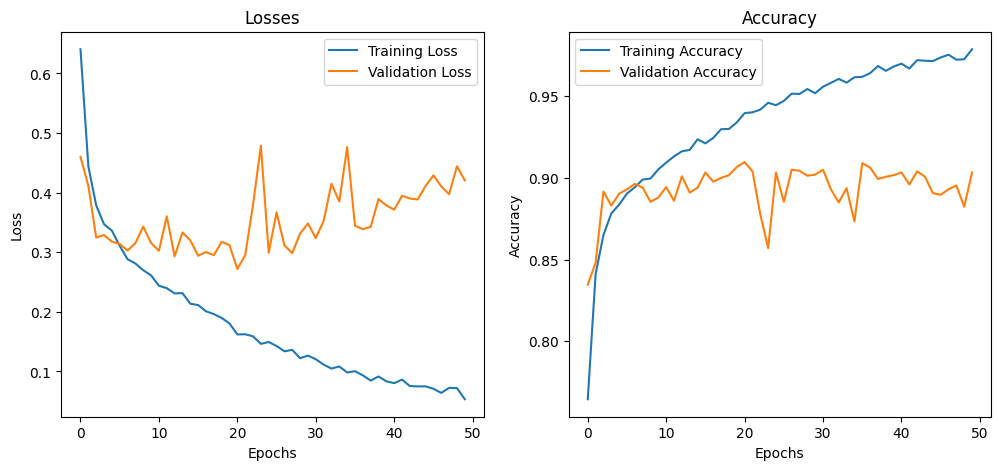

In [11]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')


# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'{model_name}_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'{model_name}_{timestamp}.png'))

# 画像を表示
plt.show()
